In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/course_lead_scoring.csv")

In [3]:
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data Preparation

In [4]:
df.isnull().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


### Function for missing value handling

In [5]:
def missing_value_handling(df):
  for col in df.select_dtypes(include='object').columns:
    df[col].fillna('NA',inplace=True)

  for col in df.select_dtypes(include=['float','int64']).columns:

    df[col].fillna(0,inplace=True)

  return df

In [6]:
df = missing_value_handling(df)

/tmp/ipython-input-1245809880.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NA',inplace=True)
/tmp/ipython-input-1245809880.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [7]:
df.isnull().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


### Data Splitting

In [8]:
X = df.drop(['converted'],axis=1)
y = df['converted']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.40, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.50, random_state = 1 )

### Q1. ROC AUC Score

In [10]:
from sklearn.metrics import roc_auc_score

for col in X_train.select_dtypes(include=['float','int64']).columns:

  auc = roc_auc_score(y_train, X_train[col])

  if auc < 0.5:

    auc = roc_auc_score(y_train, -X_train[col])

  print(f'{col} : {auc}')

number_of_courses_viewed : 0.7652439024390244
annual_income : 0.5446354552990968
interaction_count : 0.7271914132379249
lead_score : 0.6111168681007025


### Q2. Training the Model

In [11]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()

X_train_dicts = X_train.to_dict(orient='records')
X_val_dicts = X_val.to_dict(orient='records')

X_train_encoded = dv.fit_transform(X_train_dicts)
X_val_encoded = dv.transform(X_val_dicts)


In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [13]:
y_pred = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.794


### Q3. Precision and Recall

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


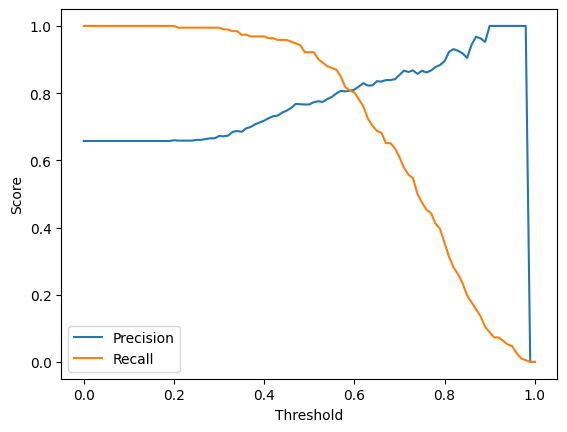

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls =[]

for t in thresholds:

  preds = (y_pred >= t)
  precisions.append(precision_score(y_val, preds))
  recalls.append(recall_score(y_val, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show()

### Q4. F1 **Score**

In [15]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    preds = (y_pred >= t)
    f1_scores.append(f1_score(y_val, preds))

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold = {best_t:.3f}")
print(f"Best F1 score = {best_f1:.3f}")


Best threshold = 0.470
Best F1 score = 0.848


### Q5. 5-Fold CV

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df):
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]

    y_train = df_train['converted']
    y_val = df_val['converted']

    X_train = df_train.drop('converted', axis=1)
    X_val = df_val.drop('converted', axis=1)

    dv = DictVectorizer(sparse=False)

    train_dicts = X_train.to_dict(orient='records')
    val_dicts = X_val.to_dict(orient='records')

    X_train_dv = dv.fit_transform(train_dicts)
    X_val_dv = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_dv, y_train)

    y_pred = model.predict_proba(X_val_dv)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)



print("AUC scores per fold:", scores)
print("Mean AUC:", round(np.mean(scores), 3))
print("Std AUC:", round(np.std(scores), 3))


AUC scores per fold: [np.float64(0.8172202350536536), np.float64(0.7792846497764531), np.float64(0.8309278350515464), np.float64(0.8675988428158148), np.float64(0.8093413173652695)]
Mean AUC: 0.821
Std AUC: 0.029


### Q6. Hyperparamater tuning

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np


C_values = [0.000001, 0.001, 1]


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        y_train = df_train['converted']
        y_val = df_val['converted']

        X_train = df_train.drop('converted', axis=1)
        X_val = df_val.drop('converted', axis=1)


        dv = DictVectorizer(sparse=False)
        X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_dv = dv.transform(X_val.to_dict(orient='records'))


        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_dv, y_train)


        y_pred = model.predict_proba(X_val_dv)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)


    mean_auc = round(np.mean(scores), 3)
    std_auc = round(np.std(scores), 3)
    results.append((C, mean_auc, std_auc))


for C, mean_auc, std_auc in results:
    print(f"C={C}: mean AUC={mean_auc}, std={std_auc}")


results.sort(key=lambda x: (-x[1], x[2], x[0]))
best_C = results[0][0]
print(f"\nBest C value: {best_C}")


C=1e-06: mean AUC=0.549, std=0.03
C=0.001: mean AUC=0.862, std=0.024
C=1: mean AUC=0.821, std=0.029

Best C value: 0.001
